# MNIST TUTORIAL

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/01-mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.



Note: you may need to restart the kernel to use updated packages.
nohup eva_server > eva.log 2>&1 &


Note: you may need to restart the kernel to use updated packages.


### Downloading the videos

In [2]:
# Getting MNIST as a video
!wget -nc https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4
# Getting a udf
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/apps/mnist/eva_mnist_udf.py

--2023-05-11 05:08:33--  https://www.dropbox.com/s/yxljxz6zxoqu54v/mnist.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.


HTTP request sent, awaiting response... 

302 Found
Location: /s/raw/yxljxz6zxoqu54v/mnist.mp4 [following]
--2023-05-11 05:08:33--  https://www.dropbox.com/s/raw/yxljxz6zxoqu54v/mnist.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 

302 Found
Location: https://uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com/cd/0/inline/B73MT-tqMw4G9IfbRtKzhM8NhIzx_3l9UOFf0nVjx9KxhsjjmSfVTSjfsDkbhEzL5otFJnD4Jw_sqSVhZ9skT0Eod-91CIYiZLD0aFsoLIPS5VLQCVBexrzgjVE1ZNX2BedMIA7LlnATbWeTVSyl4rsQmHBIt8x_TApZO3jviZ7XcA/file# [following]
--2023-05-11 05:08:34--  https://uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com/cd/0/inline/B73MT-tqMw4G9IfbRtKzhM8NhIzx_3l9UOFf0nVjx9KxhsjjmSfVTSjfsDkbhEzL5otFJnD4Jw_sqSVhZ9skT0Eod-91CIYiZLD0aFsoLIPS5VLQCVBexrzgjVE1ZNX2BedMIA7LlnATbWeTVSyl4rsQmHBIt8x_TApZO3jviZ7XcA/file
Resolving uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com (uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com)... 

162.125.5.15, 2620:100:601f:15::a27d:90f
Connecting to uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com (uc095cbfd2a3b07b85fd3df6e4c5.dl.dropboxusercontent.com)|162.125.5.15|:443... connected.


HTTP request sent, awaiting response... 

200 OK
Length: 62156 (61K) [video/mp4]
Saving to: ‘mnist.mp4’

mnist.mp4             0%[                    ]       0  --.-KB/s               

mnist.mp4           100%[===================>]  60.70K  --.-KB/s    in 0.03s   

2023-05-11 05:08:37 (2.32 MB/s) - ‘mnist.mp4’ saved [62156/62156]



--2023-05-11 05:08:37--  https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/apps/mnist/eva_mnist_udf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 3021 (3.0K) [text/plain]
Saving to: ‘eva_mnist_udf.py’

eva_mnist_udf.py    100%[===================>]   2.95K  --.-KB/s    in 0s      

2023-05-11 05:08:37 (25.0 MB/s) - ‘eva_mnist_udf.py’ saved [3021/3021]



### Upload the video for analysis

In [3]:
cursor.execute('DROP TABLE IF EXISTS MNISTVid')
response = cursor.fetch_all()
response.as_df()
cursor.execute("LOAD VIDEO 'mnist.mp4' INTO MNISTVid")
response = cursor.fetch_all()
response.as_df()

,0
0,Number of loaded VIDEO: 1


### Visualize Video

In [4]:
from IPython.display import Video
Video("mnist.mp4", embed=True)

### Create an user-defined function (UDF) for analyzing the frames

In [5]:
cursor.execute("""CREATE UDF IF NOT EXISTS
                  MnistCNN 
                  INPUT  (data NDARRAY (3, 28, 28))
                  OUTPUT (label TEXT(2))
                  TYPE  Classification
                  IMPL  'eva_mnist_udf.py'
        """)
response = cursor.fetch_all()
response.as_df()

,0
0,UDF MnistCNN successfully added to the database.


### Run the Image Classification UDF on video

In [6]:
cursor.execute("""SELECT data, MnistCNN(data).label 
                  FROM MNISTVid
                  WHERE id = 30 OR id = 50 OR id = 70 OR id = 0 OR id = 140""")
response = cursor.fetch_all()
response.as_df()

,mnistvid.data,mnistcnn.label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",6
1,"[[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...",2
2,"[[[13, 13, 13], [2, 2, 2], [2, 2, 2], [13, 13,...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",7
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",5


### Visualize output of query on the video

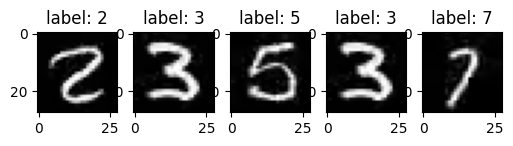

In [7]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[6,8])

df = response.batch.frames
for axi in ax.flat:
    idx = np.random.randint(len(df))
    img = df['mnistvid.data'].iloc[idx]
    label = df['mnistcnn.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()